In [10]:
# Auto-reload setup
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
print(sys.executable)

sys.path.append(os.path.abspath("../src"))
from plotting_price_drivers import *
from merit_order import *

/usr/local/bin/python3


In [13]:
master_path = '../data/clean/fbmc/master_dataset_15min.csv'
df = pd.read_csv(master_path, parse_dates=['Time'])

   Unnamed: 0                Time    Area  Generation  Total load  \
0           0 2025-01-01 00:00:00  BZN|BE     9656.79     8233.79   
1           1 2025-01-01 00:15:00  BZN|BE     9656.79     8126.86   
2           2 2025-01-01 00:30:00  BZN|BE     9656.79     8057.30   
3           3 2025-01-01 00:45:00  BZN|BE     9656.79     7962.76   
4           4 2025-01-01 01:00:00  BZN|BE     9698.60     7885.99   

   Net position  Renewable share import/export flag  day  
0       1423.00                0             export    1  
1       1529.93                0             export    1  
2       1599.49                0             export    1  
3       1694.03                0             export    1  
4       1812.61                0             export    1  


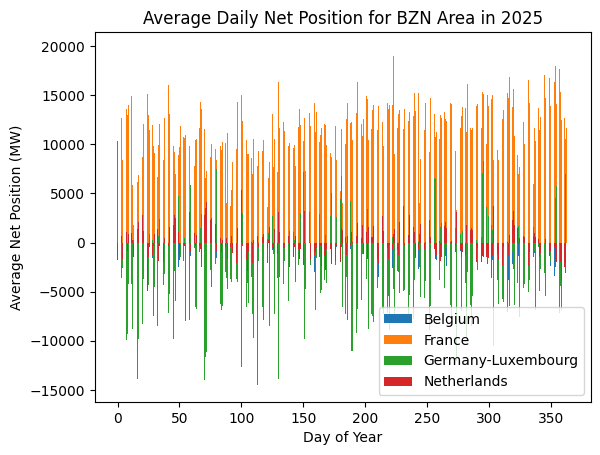

In [25]:
df['day'] = df['Time'].dt.dayofyear
print(df.head())

plt.bar(range(0,363),df[df['Area'] == 'BZN|BE'].groupby('day')['Net position'].mean(), width=0.5)
plt.bar(range(0,365),df[df['Area'] == 'BZN|FR'].groupby('day')['Net position'].mean(), width=0.5)
plt.bar(range(0,363),df[df['Area'] == 'BZN|DE-LU'].groupby('day')['Net position'].mean(), width=0.5)
plt.bar(range(0,363),df[df['Area'] == 'BZN|NL'].groupby('day')['Net position'].mean(), width=0.5)
plt.xlabel('Day of Year')
plt.ylabel('Average Net Position (MW)')
plt.title('Average Daily Net Position for BZN Area in 2025')
plt.legend(['Belgium', 'France', 'Germany-Luxembourg', 'Netherlands'])
plt.show()